#  (MAS473) Introduction to Artificial Intelligence with Mathematics
# Homework #1: Introduction to the Neural Network

# 1. Prerequisites

The purpose of this homework is to practice for implementing some basic neural networks.

You can use following packages in this HW:

##  Data Loading

### Download data
Gathering proper dataset for given tasks is a starting point of solving a deep learning problem.
In our tutorial, we use ```torchvision.datasets``` class, which provides diverse benchmark datasets for various deep learning tasks. The following are some main parameters of the class.
* **root**(string) - Root directory of dataset
* **train**(bool) - If true, creates dataset for training, otherwise for test.
* **download**(bool) - If false, dataset is not downloaded again.
* **transform**(callable) - A function/transform that takes in an PIL image and returns a transformed version.

MNIST data contains 60,000 training and 10,000 test images. They are images of numbers and labels of the numbers.

https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.MNIST

If you want to use your own data, we prepare the data with csv file (obviously other types ok) and upload into the Google drive and set the file directory.

In [ ]:
!pip install torch torchvision

In [ ]:
import torchvision
import torchvision.transforms as transforms

trainset_mnist = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
testset_mnist = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 105949403.16it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 91978507.08it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24368633.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21238047.68it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



###Dataloader

After the dataset is prepared, we need an appropriate tool to process the data.
We use ```torch.utils.data.DataLoader``` module for the purpose.


* **dataset**(Dataset) - dataset.
* **batch_size**(int) - how many samples per mini-batch to load.
* **sampler**(Sampler) - defines the strategy to draw samples from the dataset.

In our case, sampler will be used to train a part of the dataset. This will speed up the process. If you want to run the code with more samples, increase ```ratio_split = data_ratio``` ($< 1$) or set ```sampler = None```.

https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader


In [ ]:
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

def dataset_sampler(ratio_split, len_dataset):

    # set parameter
    offset_split = int(np.floor(ratio_split * len_dataset))
    indices = list(range(len_dataset))

    # shuffle
    np.random.shuffle(indices)

    # set samplers
    sampler = SubsetRandomSampler(indices[:offset_split])

    return sampler

data_ratio = 0.1
batch_size = 8


train_sampler = dataset_sampler(data_ratio, len(trainset_mnist))
train_loader = DataLoader(dataset = trainset_mnist, batch_size = batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset = testset_mnist, batch_size = batch_size)

### Visualizer
Let us show what the dataset contains and how the dataloader works.
The results should show what the images are.

        7       2       2       1       1       5       2       1


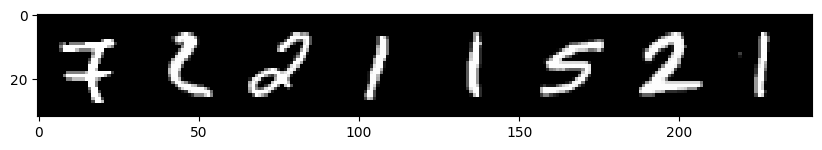

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# get some images

dataiter = iter(train_loader)
images, labels = next(dataiter)

# functions setting to show an image

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.cmap'] = 'gray'

# show images
plt.imshow(torchvision.utils.make_grid(images).permute(1,2,0))
# print labels
print('  '+' '.join('%7s' % labels[j].item() for j in range(8)))


#Implemeting a neural network


## 1. Define a network
### Design your network - multiclass classifier

Our final goal is to obtain a neural network that distinguish images of numbers.
* When the input of the network is an image of a number, the output should be a vector of 10 elements, which $i$th component representing probability of the given input being an image of number $i$ - like logistic regression.  


* Whether elements in the vector satisfy the axiom of probability(i.e., $0\le p_i\le 1, \sum p_i =1$) does not matter right now. We will see why.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyNetwork(nn.Module):
    def __init__(self, params):
        super(MyNetwork, self).__init__()
        self.data_size = params['data_size']
        self.hidden_units = params['hidden_units']
        self.layers = nn.Sequential(
            nn.Linear(self.data_size, self.hidden_units),
            nn.ReLU(),
            nn.Linear(self.hidden_units, 10))

    def forward(self, x):

        return F.softmax(self.layers(x), dim=1)

## 2. Loss function
We designed a neural network with parameters. Then, a loss function is used to optimize parameters. One of basic options is **cross entropy loss**. Minimizing cross-entropy loss is equivalent to minimizing KL divergence, which measures the difference between two distributions.

$$H(p,q) = -\sum p(x) \log q(x)$$

In our case, we would get $q_i, i=0,...,9$ as an output of network. The target distribution $p$ is, $p_i(x) = 1$ if $x$ is an image of number $i$, and $p_i(x) = 0$ otherwise. That is, $p(y) = 1$ for some $y$, $H(p,q) = -\log q(y)$


Before getting to an example of computing cross-entropy loss using ```torch.nn```, the function is implemented in reality as following.

$$loss(\text{output}, label) = -\text{output}[label] + \log \Big( \sum_{i: \text{ possible labels}} \exp(\text{output} (i)) \Big) .$$

As you see, the only difference is softmax function in ```nn.CrossEntropyLoss```. Therefore, we do not have to worry whether the output is larger than 1, or even less than 0. Note that all the computation is done parallel, sample-wise in mini-batch and then averaged.

Here is an example of the function, classification of 4 categories, two samples in a mini-batch.
Check the computed loss by ```criterion``` function. The result from concatenated one is an average of other two.


https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss

In [ ]:
criterion = nn.CrossEntropyLoss()
a = torch.tensor([[3, 0.1, -7, 0]])
b = torch.tensor([[0.3, 0.1, -20, 100]])
c = torch.cat((a,b))
print(c)
print(criterion(a, torch.tensor([0])).item())
print(criterion(b, torch.tensor([2])).item())
print(criterion(c, torch.tensor([0,2])).item())

tensor([[  3.0000,   0.1000,  -7.0000,   0.0000],
        [  0.3000,   0.1000, -20.0000, 100.0000]])
0.09971469640731812
120.0
60.04985809326172


## 3. Train
### Optimizer
Let us optimize our parameters of network with the loss function. As soon as we compute loss of output of network, autograd leaves mark of operations, so ```backward()```
computes a gradient in parameter space.
This is what we have learned in pytorch tutorial previously. ```torch.optim``` class is initialized with parameters of a network, and ```step()``` method modifies parameters simultaneously by the computed gradient. Next, using ```zero_grad()```, we delete the recorded gradient for next optmization step. We will see how these items are organized in training step.

### Hyperparameter
Before diving into the training process, we have to determine hyperparameters. For example, the number of epochs for training, a optimizer to employ, and magnitude of learning rate for the optimizer. Of course, the number of samples and images to load in one mini-batch are all hyperparameters - even designing network architecture.

The following are some hyperparameters that we mainly adjust during training.
*  **epoch** : the number of iterations for the whole dataset in gradient descent
*   **loss_show_freq** : interval of recording average loss during training
*   **learning_rate** : step size of gradient descent (parameter of optimizer)

In [ ]:
# hyperparameters
epoch = 300
loss_show_freq = 2
learning_rate = 0.005

The following code calls a network, a loss, and an optimizer. Then, the network is trained. After the training is finished, the graph of average loss appears.


>> TRAIN 
cuda:0  will be used.

>> 868 second / 14 minutes expected 
Epoch[2] Loss = 2.285884
Epoch[4] Loss = 2.223319
Epoch[6] Loss = 2.126781
Epoch[8] Loss = 1.953934
Epoch[10] Loss = 1.833696
Epoch[12] Loss = 1.787800
Epoch[14] Loss = 1.765039
Epoch[16] Loss = 1.750976
Epoch[18] Loss = 1.741058
Epoch[20] Loss = 1.733207
Epoch[22] Loss = 1.709674
Epoch[24] Loss = 1.684438
Epoch[26] Loss = 1.671807
Epoch[28] Loss = 1.662994
Epoch[30] Loss = 1.656164
Epoch[32] Loss = 1.650588
Epoch[34] Loss = 1.645959
Epoch[36] Loss = 1.642161
Epoch[38] Loss = 1.638847
Epoch[40] Loss = 1.635937
Epoch[42] Loss = 1.633331
Epoch[44] Loss = 1.630906
Epoch[46] Loss = 1.628856
Epoch[48] Loss = 1.626894
Epoch[50] Loss = 1.625104
Epoch[52] Loss = 1.623495
Epoch[54] Loss = 1.621870
Epoch[56] Loss = 1.620566
Epoch[58] Loss = 1.619195
Epoch[60] Loss = 1.617983
Epoch[62] Loss = 1.616798
Epoch[64] Loss = 1.615563
Epoch[66] Loss = 1.614624
Epoch[68] Loss = 1.613595
Epoch[70] Loss = 1.612618
Epoch[72] Loss = 1.6116

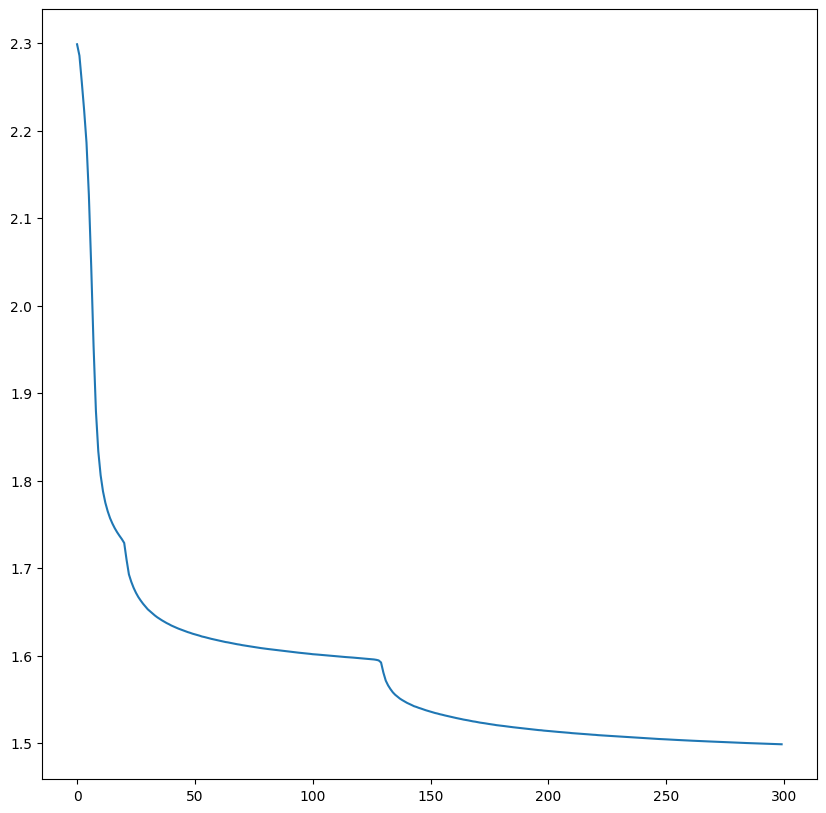

In [ ]:
import time

print("\n>> TRAIN ")
params = {'data_size': 784,
         'hidden_units' : 256}
loss_arr=[]

device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

net = MyNetwork(params).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)


for i in range(epoch):
    loss_sum = 0
    if (i == 0):
        t1 = time.time()

    for j, [image, label] in enumerate(train_loader):
        # Get batch size.
        bs = image.size(0)
        # Flatten the image.
        image = image.view(bs, -1).to(device)
        label = label.to(device)
        optimizer.zero_grad()
        result = net.forward(image)
        loss = criterion(result, label)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()

    # Loss #######
    loss_mean = loss_sum * (batch_size / (data_ratio * (len(trainset_mnist))))
    loss_arr.append(loss_mean)
    if ((i+1)%loss_show_freq==0):
        print('Epoch[%d] Loss = %f'%((i+1), loss_mean))

    # time #######
    if (i == 0):
        t2 = time.time()
        duration = t2-t1
        train_time = duration * epoch
        print(">> %d second / %d minutes expected " % (train_time, train_time / 60))

plt.figure(1)
plt.plot(loss_arr)
plt.show()

## 4. Test
We can test performance of the trained network. Notice that we use another dataloader, ```test_loader```

In [ ]:
print("\n>> TEST ")
net.eval()
correct = 0
total = 0

for image, label in test_loader:
    #image = Variable(image)#.cuda()
    bs = image.size(0)
    # Flatten the image.
    image = image.view(bs, -1).to(device)
    label = label.to(device)
    result = net(image)#.cuda()
    _, predicted = torch.max(result.data, 1)
    total += label.size(0)
    correct += (predicted == label).sum()#.cuda()).sum()
print(' Test Accuracy of the model on the 10000 test images:  %f %%' % (100 * correct / total))




>> TEST 
 Test Accuracy of the model on the 10000 test images:  92.809998 %


#  HOMEWORK

Using the above, you create a Fully Connected Neural Network or Convolutional Neural Network to learn the MNIST dataset.

Your network should satisfy


1.   the number of hidden layers of the neural network is larger than 2
2.   the test accuracy should exeed 94%.


Hint :



*   You can find a lot of examples in google or github. It is fine to adapt those examples in our model. but you should not copy them totally.
*   In the pytorch documents, you can find definitions of the parameters in pytorch. Please visit the official site.
*   For example, you can change **epoch**, **learning rate**, **loss function** , **structure of the neural networks** **,the size of the batch** , **optimizer** and so on. (For later Homeworks, I recommand you try to do these.
*   If you want to use another tools such as keras, tensorflow etc, it is ok but you have to explain the each code you wrote.



https://pytorch.org/docs/stable/index.html








In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyNetwork(nn.Module):
    def __init__(self, params):
        super(MyNetwork, self).__init__()
        self.data_size = params['data_size']

        # First Hidden Layer: Convolutional layer, ReLU & MaxPool

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )

        # Second Hidden Layer: Convolutional layer, ReLU & MaxPool

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Last Hidden Layer: Linear layer

        self.fc = nn.Linear(5 * 5 * 64, 10, bias=True)  # Stride와 MaxPooling 이후로 data가 28*28에서 5*5로 변환됨.

        # initialize the weight for the linear layer
        nn.init.xavier_uniform_(self.fc.weight)


    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)

        return out

In [ ]:
# hyperparameters , you have to set proper hyperparameters. It is ok using the above.
epoch = 20
learning_rate = 0.005


>> TRAIN 
cuda:0  will be used.

>> 49 second / 0 minutes expected 
Epoch[2] Loss = 0.423288
Epoch[4] Loss = 0.246612
Epoch[6] Loss = 0.175529
Epoch[8] Loss = 0.134614
Epoch[10] Loss = 0.108887
Epoch[12] Loss = 0.091303
Epoch[14] Loss = 0.078488
Epoch[16] Loss = 0.067198
Epoch[18] Loss = 0.058896
Epoch[20] Loss = 0.050925


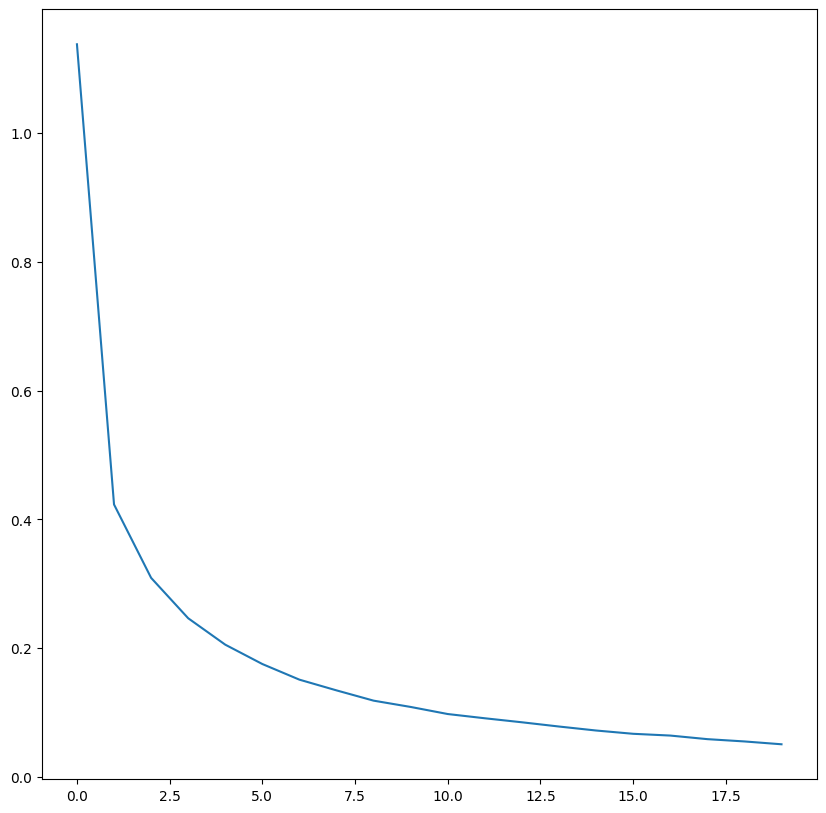

In [ ]:
import time

print("\n>> TRAIN ")
params = {'data_size': 784,
          }
loss_arr=[]

device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

net = MyNetwork(params).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)


for i in range(epoch):
    loss_sum = 0
    if (i == 0):
        t1 = time.time()

    for j, [image, label] in enumerate(train_loader):
        # Get batch size.
        bs = image.size(0)
        # Flatten the image.
        # image = image.view(bs, -1).to(device)
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        result = net.forward(image)
        loss = criterion(result, label)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()

    # Loss #######
    loss_mean = loss_sum * (batch_size / (data_ratio * (len(trainset_mnist))))
    loss_arr.append(loss_mean)
    if ((i+1)%loss_show_freq==0):
        print('Epoch[%d] Loss = %f'%((i+1), loss_mean))

    # time #######
    if (i == 0):
        t2 = time.time()
        duration = t2-t1
        train_time = duration * epoch
        print(">> %d second / %d minutes expected " % (train_time, train_time / 60))

plt.figure(1)
plt.plot(loss_arr)
plt.show()

In [ ]:
print("\n>> TEST ")
net.eval()
correct = 0
total = 0

for image, label in test_loader:
    #image = Variable(image)#.cuda()
    bs = image.size(0)
    # Flatten the image.
    # image = image.view(bs, -1).to(device)
    image = image.to(device)
    label = label.to(device)
    result = net(image)#.cuda()
    _, predicted = torch.max(result.data, 1)
    total += label.size(0)
    correct += (predicted == label).sum()#.cuda()).sum()
print(' Test Accuracy of the model on the 10000 test images:  %f %%' % (100 * correct / total))




>> TEST 
 Test Accuracy of the model on the 10000 test images:  97.309998 %
